In [1]:
import json
from collections import defaultdict
from copy import deepcopy

import gdsfactoryplus.models as m
import matplotlib.pyplot as plt
import networkx as nx
from gdsfactoryplus import settings
from gdsfactoryplus.core.callgraph import (
    _color_map,
    _is_valid_node,
    cg,
    create_callgraph,
    default_lib_paths,
    plot_callgraph,
)
from gdsfactoryplus.core.pdk import *

CPU times: user 774 ms, sys: 82.8 ms, total: 857 ms
Wall time: 858 ms


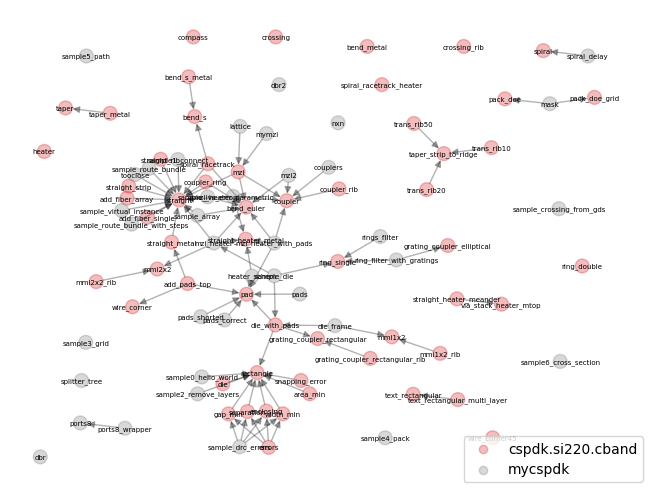

In [2]:
%time G = create_callgraph()
plot_callgraph(G)

In [3]:
def get_static_records(G, paths):
    paths_given = bool(paths)
    paths = [Path(p).resolve() for p in paths]
    static_records = {}
    for factory_name in nx.topological_sort(nx.reverse_view(G)):
        props = G.nodes[factory_name]
        relevant_paths = [Path(props['source']).resolve(), *(Path(p).resolve() for p in props['other_sources'])]
        if paths_given and not any(p==q for p in paths for q in relevant_paths):
            continue
        static_records[factory_name] = m.FactoryRecord.from_callgraph(G, factory_name)
    return static_records

In [4]:
def import_modules(static_records, paths):
    _paths = list({r.absolute_source(): None for r in static_records.values()}) # keep order
    paths = _paths if not paths else [p for p in _paths if p in paths]
    modules, errors = imports.import_modules(paths=paths, reload=reload, from_project=False)
    modules = {k: m for k, m in ((p, modules.get(p, None)) for p in paths) if m}
    errors = {k: e for k, e in ((p, errors.get(p, None)) for p in paths) if e}
    return modules, errors

In [5]:
def handle_import_errors(static_records, static_records_by_path, errors) -> tuple[dict[str, Callable], dict[str, m.FactoryRecord]]:
    error_cells = {}
    error_records = {}

    for path, (modname, error) in errors.items():
        log().warning(f"{path.name}: {error}")
        try:
            regex_names = imports.get_cells_from_regex(path)
        except Exception:  # noqa: BLE001,S112
            continue  # TODO: handle this better (probably a .pic.yml file)
        # this one should include partials:
        static_names = [r.name for r in static_records_by_path.get(path, [])]
        for name in {*regex_names, *static_names}:
            cell = _error_cell(name, modname, error)
            error_cells[name] = cell
            record = static_records.get(name)
            if record is None:
                record = db.FactoryRecord(
                    name=name,
                    source=str(path),
                    status="ERROR",
                    message=str(error),
                )
            else:
                record = deepcopy(record)
                record.status = "ERROR"
                record.message = str(error)
            error_records[name] = record
    return error_cells, error_records

In [6]:
def _error_cell(funcname: str, modname: str, error: str | Exception) -> Callable:
    if isinstance(error, str):
        error = RuntimeError(error)

    def func(*args: Any, **kwargs: Any) -> gf.Component:  # noqa: ARG001
        raise error

    func.__name__ = funcname
    func.__qualname__ = funcname
    func.__module__ = modname

    return func

[]

**TODO**:
```python
    children_with_warnings = [c for c in static_record.children if getattr(static_records.get(c), 'status', 'UNKNOWN') == 'WARNING']
    if children_with_warnings:
        static_record.status = "WARNING"
        static_record.message = f"Cell '{static_record.name}' depends on {children_with_warnings} with 'WARNING' status."
        
    children_with_errors = [c for c in static_record.children if getattr(static_records.get(c), 'status', 'UNKNOWN') == 'ERROR']
    if children_with_errors:
        static_record.status = "WARNING"
        static_record.message = f"Cell '{static_record.name}' depends on {children_with_errors} with 'ERROR' status."
```

In [8]:
def find_cells(static_records, modules, error_cells):
    new_cells = {}
    for name, static_record in static_records.items():
        if name in error_cells:
            new_cells[name] = error_cells[name]
            continue
        path = static_record.absolute_source()
        mod = modules.get(path)
        if mod is None:
            static_record.status = "ERROR"
            static_record.message = f"Module for cell '{static_record.name}' with path {path} not found."
            log().warning(static_record.message)
            new_cells[name] = _error_cell(name, path.name, ModuleNotFoundError(static_record.message))
        cell = getattr(mod, name, None)
        if cell is None:
            static_record.status = "ERROR"
            static_record.message = f"Cell '{static_record.name}' not found in '{path}'."
            log().warning(static_record.message)
            new_cells[name] = _error_cell(name, path.name, ImportError(static_record.message))
        new_cells[name] = cell
    return new_cells

In [18]:
def update_database(static_records, paths_given):
    if paths_given:
        present_records = db.get_factories_by_name(*static_records)
    else:
        present_records = db.get_all_factories()
        
    new_record_names = set(static_records) - set(present_records)
    new_records = [static_records[name] for name in new_record_names]
    print(f"{new_record_names=}")
    
    updated_record_names = set(static_records) & set(present_records)
    updated_records = []
    for name in updated_record_names:
        if static_records[name].source != present_records[name].source:
            updated_records.append(static_records[name])
            continue
        static_records[name].status = present_records[name].status
        static_records[name].message = present_records[name].message
        if static_records[name] == present_records[name]:
            continue
        updated_records.append(static_records[name])
    updated_record_names = {r.name for r in updated_records}
    print(f"{updated_record_names=}")
    
    deleted_record_names = set(present_records) - set(static_records)
    print(f"{deleted_record_names=}")
    for name in deleted_record_names:
        del pdk.cells[name]
        
    db.add_factories(*new_records, *updated_records, update_last_modified=True)
    db.remove_factories(*deleted_record_names)
    return sorted([*new_record_names, *updated_record_names]), sorted(deleted_record_names)

In [19]:
reload=True
paths = []

pdk = get_pdk()
base_pdk = None if settings.is_a_pdk() else get_base_pdk()
static_records = get_static_records(G, paths)
static_records_by_path = defaultdict(list)
for r in static_records.values():
    static_records_by_path[r.absolute_source()].append(r)
    
modules, errors = import_modules(static_records, paths)
error_cells, error_records = handle_import_errors(static_records, static_records_by_path, errors)
static_records.update(error_records)
new_cells = find_cells(static_records, modules, error_cells)
pdk.cells.update(new_cells)
update_database(static_records, bool(paths))

23:51:37 | WARNING  | dbr.py: No module named 'adf'
new_record_names=set()
updated_record_names=set()
deleted_record_names=set()


([], [])